In [1]:
import os

data_dir='/Users/think/Downloads/jena_climate'
fname=os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f=open(fname,encoding='utf8')
data=f.read()
f.close()

lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
# Parse the data
import numpy as np

float_data=np.zeros((len(lines),len(header)-1))
for i,line in enumerate(lines):
    values=[float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values

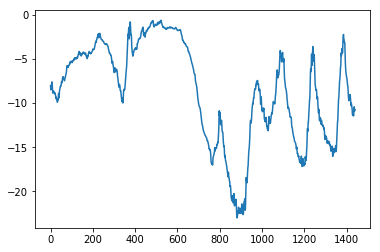

In [3]:
# plot the temperature timeseries
% matplotlib inline
import matplotlib.pyplot as plt

temp=float_data[:,1]
plt.plot(range(1440),temp[:1440])

In [4]:
# Prepare the data
# parameter values:
# lookback=720, our observations will go back 5 days
# steps=6, our observations will be sampled at one data point per hour
# delay=144, our targets will be 24 hours in the future
# min_index & max_index, indices in the data array that delimit which timeteps to draw from
# shuffle, whether to shuffle our samples or draw them in chronological order
# batch_size, the number of samples per batch

# use the first 200,000 timesteps as training data
# normalize the data
mean=float_data[:200000].mean(axis=0)
float_data -= mean
std=float_data[:200000].std(axis=0)
float_data /= std

# create a generator yielding timeseries and targets
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index=len(data)-delay-1
    i=min_index+lookback
    while 1:
        if shuffle:
            # 随机生成一个数组，最小值为min_index+lookback，最大值为max_index，长度为batch_size
            rows=np.random.randint(min_index+lookback, max_index, size=batch_size)
        else:
            if i+batch_size>=max_index:
                i=min_index+lookback
            rows=np.arange(i,min(i+batch_size, max_index))
            i += len(rows)
        
        samples=np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets=np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices=range(rows[j]-lookback, rows[j], step)
            samples[j]=data[indices]
            targets[j]=data[rows[j]+delay][1]
        yield samples, targets

lookback=1440
step=6
delay=144
batch_size=128

train_gen=generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen=generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen=generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

val_steps=(300000-200001-lookback)//batch_size
test_steps=(len(float_data)-300001-lookback)//batch_size

In [5]:
# compute the common sense baseline MAE 
# (the temperature 24 hours from now will be equal to the temperature right now)
def evaluate_naive_method():
    batch_maes=[]
    for step in range(val_steps):
        samples,targets=next(val_gen)
        preds=samples[:,-1,1]
        mae=np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)

mae=evaluate_naive_method()
# convert the MAE back to a Celsius error
celsius_mae=mae*std[1]
print(celsius_mae)

2.564887434980494


In [6]:
# train and evaluate a densely-connected model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model=Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
# steps_per_epoch：整数，当生成器返回steps_per_epoch次数据时计一个epoch结束，执行下一个epoch
# epochs：整数，数据迭代的轮数
# validation_steps: 当validation_data为生成器时，本参数指定验证集的生成器返回次数
history=model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

D:\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 13s 27ms/step - loss: 1.8761 - val_loss: 0.8369
Epoch 2/20
500/500 [==============================] - 13s 26ms/step - loss: 0.8290 - val_loss: 0.7149
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 0.4360 - val_loss: 0.3155
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3004 - val_loss: 0.3428
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2711 - val_loss: 0.3507
Epoch 6/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2564 - val_loss: 0.3215
Epoch 7/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2532 - val_loss: 0.3393
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2430 - val_loss: 0.4003
Epoch 9/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2398 - val_loss: 0.3304
Epoch 10/20
500/500 [==============================] - 13s 25ms/step - loss: 0.233

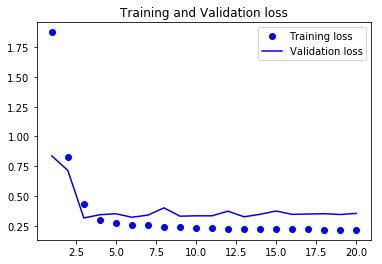

In [7]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [8]:
# train and evaluate a GRU-based model
model=Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 80s 160ms/step - loss: 0.3003 - val_loss: 0.2712
Epoch 2/20
500/500 [==============================] - 80s 161ms/step - loss: 0.2838 - val_loss: 0.2668
Epoch 3/20
500/500 [==============================] - 80s 159ms/step - loss: 0.2777 - val_loss: 0.2772
Epoch 4/20
500/500 [==============================] - 79s 159ms/step - loss: 0.2739 - val_loss: 0.2661
Epoch 5/20
500/500 [==============================] - 81s 161ms/step - loss: 0.2677 - val_loss: 0.2662
Epoch 6/20
500/500 [==============================] - 80s 160ms/step - loss: 0.2628 - val_loss: 0.2685
Epoch 7/20
500/500 [==============================] - 79s 158ms/step - loss: 0.2586 - val_loss: 0.2745
Epoch 8/20
500/500 [==============================] - 79s 159ms/step - loss: 0.2545 - val_loss: 0.2751
Epoch 9/20
500/500 [==============================] - 80s 159ms/step - loss: 0.2488 - val_loss: 0.2731
Epoch 10/20
500/500 [==============================] - 80s 160ms/step - l

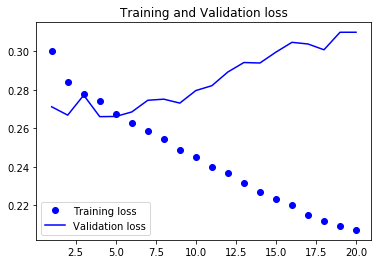

In [9]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [10]:
# Fight add dropout and recurrent dropout to the GRU layer
# dropout: a float specifies the dropout rate for input units of the layer
# recurrent_dropout: specify the dropout rate of the recurrent units
model=Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 87s 173ms/step - loss: 0.3397 - val_loss: 0.2771
Epoch 2/40
500/500 [==============================] - 85s 171ms/step - loss: 0.3145 - val_loss: 0.2737
Epoch 3/40
500/500 [==============================] - 85s 171ms/step - loss: 0.3116 - val_loss: 0.2703
Epoch 4/40
500/500 [==============================] - 86s 172ms/step - loss: 0.3038 - val_loss: 0.2771
Epoch 5/40
500/500 [==============================] - 86s 171ms/step - loss: 0.3019 - val_loss: 0.2686
Epoch 6/40
500/500 [==============================] - 85s 171ms/step - loss: 0.2973 - val_loss: 0.2704
Epoch 7/40
500/500 [==============================] - 85s 171ms/step - loss: 0.2970 - val_loss: 0.2679
Epoch 8/40
500/500 [==============================] - 86s 171ms/step - loss: 0.2948 - val_loss: 0.2662
Epoch 9/40
500/500 [==============================] - 86s 171ms/step - loss: 0.2924 - val_loss: 0.2658
Epoch 10/40
500/500 [==============================] - 85s 171ms/step - l

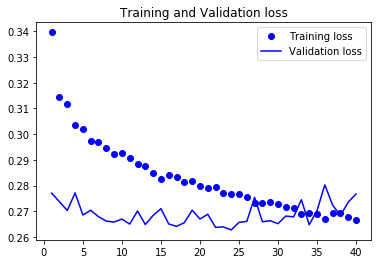

In [11]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
# Increase network capacity: stack recurrent layers
# all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep
model=Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history=model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
# Train LSTM using reversed sequences on the IMDB data
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features=10000
maxlen=500
(x_train,y_train),(x_test,y_test)=imdb.load_data(num_words=max_features)

x_train=[x[::-1] for x in x_train]
x_test=[x[::-1] for x in x_test]

x_train=sequence.pad_sequences(x_train, maxlen=maxlen)
x_test=sequence.pad_sequences(x_test,maxlen=maxlen)

model=Sequential()
model.add(layers.Embedding(max_features,128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile('rmsprop', 'binary_crossentropy', ['acc'])
model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

In [ ]:
# train and evaluate a bidirectional LSTM on the IMDB data
model=Sequential()
model.add(layers.Embedding(max_features,32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile('rmsprop','binary_crossentropy',['acc'])
model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)

In [ ]:
# train a bidirectional GRU on the Jena data
model=Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen, steps_per_epochs=500, epochs=10, validation_data=val_gen, validation_steps=val_steps)

loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()